In [1]:
import rebound
import reboundx

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy import constants as c
from astropy import units as u
from tqdm import tqdm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.style as mplstyle
mplstyle.use('fast')

# MPC

In [16]:
f = open('distant_extended.json')
data_all = json.load(f)
f.close()
data32 = [dat for dat in data_all if 39<dat['a']<40] #and dat['Num_opps']>3]
data21 = [dat for dat in data_all if 47<dat['a']<48.5] #and dat['Num_opps']>3]

In [22]:
((3340+871)/60)/24

2.9243055555555557

In [17]:
len(data32),len(data21)

(555, 206)

In [8]:
orbital_params = [pd.read_csv(f'planets_parameters/{planet}.csv') for planet in ['Jupiter','Saturn','Uranus','Neptune','Pluto']]

In [33]:
import rebound
import numpy as np
from tqdm import tqdm

# Get L7 Model 
data = data21
n_out = 10000  # Number of timesteps 
p_len = len(data)
phi_list = np.zeros((p_len,n_out)) # Array with shape [particle_index][timestep]

for it in tqdm(range(p_len)):

    sim = rebound.Simulation()
    sim.G = c.G.value
    sim.units = ('yr', 'AU', 'Msun')
    sim.integrator = "WHFAST"
    sim.dt = 2

    #############################################
    #### Select planets ####
    # For all planets use 'JSUNP', to remove a planet change letter to _
    used_planets = 'JSUN_'
    mask = [char!='_' for char in used_planets]
    #############################################

    sim.add(m=1+5.98e-6) # Sun + Inner planets

    epoch = data[it]['Epoch']
    orbital_elements = [orbital_params[i][orbital_params[i]['JDTDB']==epoch] for i in range(5)]

    masses = [0.00095465,0.00028558,0.00004344,0.00005149,0]
    for planet_index in np.array([0,1,2,3,4])[mask]:

        mass = masses[planet_index]
        elem = orbital_elements[planet_index]
        
        # Add each giant planet
        a = float(elem["A"])
        e = float(elem["EC"])
        inc = float(np.deg2rad(elem["IN"]))
        omega=float(np.deg2rad(elem["W"]))
        Omega=float(np.deg2rad(elem["OM"]))
        M = float(np.deg2rad(elem["MA"]))
        sim.add(m=mass, a=a, e=e, inc=inc, omega=omega, Omega=Omega, M=M)

    # Add asteroid
    a = data[it]['a']
    e = data[it]['e']
    inc = np.deg2rad(data[it]['i'])
    Omega = np.deg2rad(data[it]['Node'])
    omega = np.deg2rad(data[it]['Peri'])
    M = np.deg2rad(data[it]['M'])
    sim.add(a=a,e=e,Omega=Omega,inc=inc,omega=omega,M=M)
    
    sim.move_to_com()
    particles = sim.particles
    
    # Integrate the simulation, saving relevant orbital elements

    for i,t in enumerate(np.linspace(0, 1e3,n_out)):
        sim.integrate(t)

        ln              = particles[4].l
        l_particle      = particles[5].l
        pomega_particle = particles[5].pomega

        phi_list[it][i]     = np.rad2deg(2*l_particle-1*ln-pomega_particle)%360
    

100%|██████████| 150/150 [00:19<00:00,  7.79it/s]


In [10]:
amp = np.array([np.max(phi)-np.min(phi) for phi in phi_list])
mask = list((amp<355))
data_21_masked = np.array(data21)[mask]

In [21]:
np.save('MPC_21_Masked',data_21_masked)

In [40]:
len(list(np.load('MPC_32_Masked.npy',allow_pickle=True)))

214

# SMDB

In [ ]:
import requests
import json
import numpy as np

# ['5','6','7','8','9'] = ["JUPITER BARYCENTER", "SATURN BARYCENTER", "URANUS BARYCENTER", "NEPTUNE BARYCENTER", "PLUTO BARYCENTER"]
planets = ['5','6','7','8','9']
orbital_elements = []
for planet in planets:
    # Construct the API URL
    # Date is 2004-06-01
    date  = '2004-06-01'
    edate = '2004-06-02'
    units = 'AU-D'
    
    url = f"https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND='{planet}'&OBJ_DATA='YES'&MAKE_EPHEM='YES'&EPHEM_TYPE='ELEMENT'&CENTER='500@0'&START_TIME='{date}'&STOP_TIME='{edate}'&STEP_SIZE='1%20d'&CSV_FORMAT='YES&OUT_UNITS='{units}'"
    # Send an HTTP GET request to the API
    response = requests.get(url)
    
    # List: [EC, QR, IN, OM, W , Tp ,N , MA, TA ,A , AD, PR]
    #       [0   1   2   3   4   5   6   7   8   9   10  11]
    str = response.text

    #Get just the data from string ####consider using json instead####
    data = (((str.split('$$SOE\n')[1]).split('\n$$EOE')[0]).split('\n')[0][52:]).split(',')

    # Extract the orbital elements from the response
    a = eval(data[9]) # Semi-major axis (in AU)
    e = eval(data[0]) # Eccentricity
    inc = eval(data[2]) # Inclination (in degrees)
    Omega = eval(data[3]) # Longitude of the ascending node (in degrees)
    omega = eval(data[4]) # Argument of perihelion (in degrees)
    f = eval(data[8]) # True anomaly (in degrees)

    # Append the orbital elements to empty list
    orbital_elements.append({"a": a, "e": e, "inc": inc, "Omega": Omega, "omega": omega, "f": f})

# Convert degrees to radians
for elem in orbital_elements:
    elem["inc"] = np.deg2rad(elem["inc"])
    elem["omega"] = np.deg2rad(elem["omega"])
    elem["Omega"] = np.deg2rad(elem["Omega"])
    elem["f"] = np.deg2rad(elem["f"])

,name,e,a,i,Om,om,M
0,20161 (1996 TR66),0.3990,48.24,12.40,342.89,310.60,59.90
1,26308 (1998 SM165),0.3737,48.10,13.46,182.99,132.13,51.68
2,119979 (2002 WC19),0.2604,47.91,9.19,109.71,43.77,323.79
3,137295 (1999 RB216),0.3003,48.09,12.67,175.62,208.90,9.44
4,278361 (2007 JJ43),0.1593,47.92,12.06,272.53,9.20,343.91
...,...,...,...,...,...,...,...
134,(2016 UO273),0.2075,48.36,16.05,68.98,260.50,48.15
135,(2017 DN121),0.2251,47.58,15.24,353.14,128.10,16.02
136,(2017 FP161),0.1700,47.65,15.21,123.97,216.79,248.72
137,(2017 FQ161),0.2652,47.87,8.22,31.16,5.34,127.54


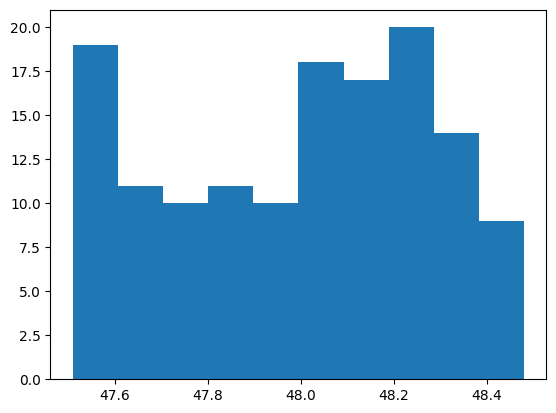

In [15]:
plt.hist(pd.read_csv('21_obs_data.csv')['a']);
pd.read_csv('21_obs_data.csv')

In [40]:
data_21 = pd.read_csv('21_obs_data.csv')
data_32 = pd.read_csv('32_obs_data.csv')
data_21

,name,e,a,i,Om,om,M
0,20161 (1996 TR66),0.3990,48.24,12.40,342.89,310.60,59.90
1,26308 (1998 SM165),0.3737,48.10,13.46,182.99,132.13,51.68
2,119979 (2002 WC19),0.2604,47.91,9.19,109.71,43.77,323.79
3,137295 (1999 RB216),0.3003,48.09,12.67,175.62,208.90,9.44
4,278361 (2007 JJ43),0.1593,47.92,12.06,272.53,9.20,343.91
...,...,...,...,...,...,...,...
134,(2016 UO273),0.2075,48.36,16.05,68.98,260.50,48.15
135,(2017 DN121),0.2251,47.58,15.24,353.14,128.10,16.02
136,(2017 FP161),0.1700,47.65,15.21,123.97,216.79,248.72
137,(2017 FQ161),0.2652,47.87,8.22,31.16,5.34,127.54


In [35]:
import rebound
import numpy as np
from tqdm import tqdm

# Get L7 Model 
data = data_21
n_out = 10000  # Number of timesteps 
p_len = len(data)
phi_list = np.zeros((p_len,n_out)) # Array with shape [particle_index][timestep]

for it in tqdm(range(p_len)):

    sim = rebound.Simulation()
    sim.G = c.G.value
    sim.units = ('yr', 'AU', 'Msun')
    sim.integrator = "WHFAST"
    sim.dt = 2

    #############################################
    #### Select planets ####
    # For all planets use 'JSUNP', to remove a planet change letter to _
    used_planets = 'JSUN_'
    mask = [char!='_' for char in used_planets]
    #############################################

    sim.add(m=1+5.98e-6)
    masses = [0.00095465,0.00028558,0.00004344,0.00005149,0]
    for i in np.array([0,1,2,3,4])[mask]:
        mass = masses[i]
        elem = orbital_elements[i]
        sim.add(m=mass, a=elem["a"], e=elem["e"], inc=elem["inc"], omega=elem["omega"], Omega=elem["Omega"], f=elem["f"])
    sim.move_to_com()

    # add 2:1 object
    sim.add(m=0,a=list(data['a'])[it],e=list(data['e'])[it],Omega=np.deg2rad(list(data['Om'])[it]),inc=np.deg2rad(list(data['i'])[it]),omega=np.deg2rad(list(data['om'])[it]),M=np.deg2rad(list(data['M'])[it]))
    # add planet 9
    sim.add(m=1.8621634e-5,a=382.4,inc=np.deg2rad(15.6),e=0.2,pomega=np.deg2rad(247.6),Omega=np.deg2rad(97.5))
    
    particles = sim.particles

    # Integrate the simulation, saving relevant orbital elements

    for i,t in enumerate(np.linspace(0, 1e7,n_out)):
        sim.integrate(t)

        ln              = particles[4].l
        l_particle      = particles[5].l
        pomega_particle = particles[5].pomega

        phi_list[it][i]     = np.rad2deg(2*l_particle-1*ln-pomega_particle)%360
    

100%|██████████| 139/139 [12:47<00:00,  5.52s/it]


In [36]:
np.save('phi_list_21_obs_p9',phi_list)

In [37]:
import rebound
import numpy as np
from tqdm import tqdm

# Get L7 Model 
data = data_32
n_out = 10000  # Number of timesteps 
p_len = len(data)
phi_list = np.zeros((p_len,n_out)) # Array with shape [particle_index][timestep]

for it in tqdm(range(p_len)):

    sim = rebound.Simulation()
    sim.G = c.G.value
    sim.units = ('yr', 'AU', 'Msun')
    sim.integrator = "WHFAST"
    sim.dt = 2

    #############################################
    #### Select planets ####
    # For all planets use 'JSUNP', to remove a planet change letter to _
    used_planets = 'JSUN_'
    mask = [char!='_' for char in used_planets]
    #############################################

    sim.add(m=1+5.98e-6)
    masses = [0.00095465,0.00028558,0.00004344,0.00005149,0]
    for i in np.array([0,1,2,3,4])[mask]:
        mass = masses[i]
        elem = orbital_elements[i]
        sim.add(m=mass, a=elem["a"], e=elem["e"], inc=elem["inc"], omega=elem["omega"], Omega=elem["Omega"], f=elem["f"])
    sim.move_to_com()

    # add 2:1 object
    sim.add(m=0,a=list(data['a'])[it],e=list(data['e'])[it],Omega=np.deg2rad(list(data['Om'])[it]),inc=np.deg2rad(list(data['i'])[it]),omega=np.deg2rad(list(data['om'])[it]),M=np.deg2rad(list(data['M'])[it]))
    # add planet 9
    sim.add(m=1.8621634e-5,a=382.4,inc=np.deg2rad(15.6),e=0.2,pomega=np.deg2rad(247.6),Omega=np.deg2rad(97.5))
    
    particles = sim.particles

    # Integrate the simulation, saving relevant orbital elements

    for i,t in enumerate(np.linspace(0, 1e7,n_out)):
        sim.integrate(t)

        ln              = particles[4].l
        l_particle      = particles[5].l
        pomega_particle = particles[5].pomega

        phi_list[it][i]     = np.rad2deg(3*l_particle-2*ln-pomega_particle)%360
    

100%|██████████| 546/546 [50:38<00:00,  5.56s/it]


In [38]:
np.save('phi_list_32_obs_p9',phi_list)